In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "../image_dataset/cropped/image"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42,
                                             label_mode = 'categorical')
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42,
                                             label_mode = 'categorical')

Found 45198 files belonging to 5 classes.
Using 36159 files for training.
Found 45198 files belonging to 5 classes.
Using 9039 files for validation.


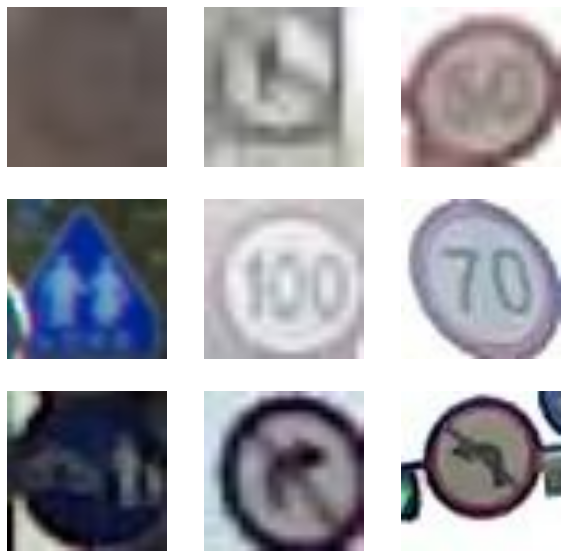

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential([])
    #data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.1))
    ### END CODE HERE
    
    return data_augmentation

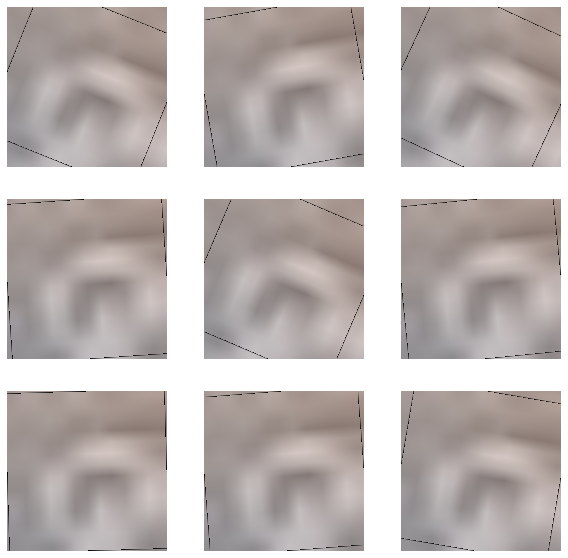

In [8]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [11]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [13]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n03207941', 'dishwasher', 0.10249795),
  ('n03041632', 'cleaver', 0.0841131)],
 [('n01496331', 'electric_ray', 0.28845868),
  ('n01955084', 'chiton', 0.28590915)],
 [('n04525038', 'velvet', 0.6188596),
  ('n04591157', 'Windsor_tie', 0.029185737)],
 [('n03447721', 'gong', 0.13696311), ('n13044778', 'earthstar', 0.05582092)],
 [('n04525038', 'velvet', 0.20327541), ('n04548362', 'wallet', 0.148841)],
 [('n04286575', 'spotlight', 0.073764056),
  ('n03729826', 'matchstick', 0.040638655)],
 [('n01776313', 'tick', 0.24073689), ('n03447721', 'gong', 0.11726197)],
 [('n02865351', 'bolo_tie', 0.3763205),
  ('n04328186', 'stopwatch', 0.24975191)],
 [('n03447721', 'gong', 0.08545833), ('n01930112', 'nematode', 0.069370866)],
 [('n03706229', 'magnetic_compass', 0.4149873),
  ('n03447721', 'gong', 0.11516195)],
 [('n04328186', 'stopwatch', 0.20365134),
  ('n03197337', 'digital_watch', 0.15690029)],
 [('n02843684', 'birdhouse', 0.92971754),
  ('n02480495', 'orangutan', 0.0027940348)],
 [('n033147

In [14]:
# UNQ_C2
# GRADED FUNCTION
def traffic_sign_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    #x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(inputs) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(5,activation='softmax')(x)
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [15]:
model2 = traffic_sign_model(IMG_SIZE, data_augmentation)

In [16]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                

In [18]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
1130/1130 [==============================] - 277s 245ms/step - loss: 0.3653 - accuracy: 0.8635 - val_loss: 0.2409 - val_accuracy: 0.9129
Epoch 2/5
1130/1130 [==============================] - 274s 243ms/step - loss: 0.2447 - accuracy: 0.9109 - val_loss: 0.2229 - val_accuracy: 0.9171
Epoch 3/5
1130/1130 [==============================] - 274s 243ms/step - loss: 0.2219 - accuracy: 0.9190 - val_loss: 0.2018 - val_accuracy: 0.9280
Epoch 4/5
1130/1130 [==============================] - 275s 244ms/step - loss: 0.2115 - accuracy: 0.9222 - val_loss: 0.1988 - val_accuracy: 0.9295
Epoch 5/5
1130/1130 [==============================] - 275s 243ms/step - loss: 0.2083 - accuracy: 0.9236 - val_loss: 0.1986 - val_accuracy: 0.9286


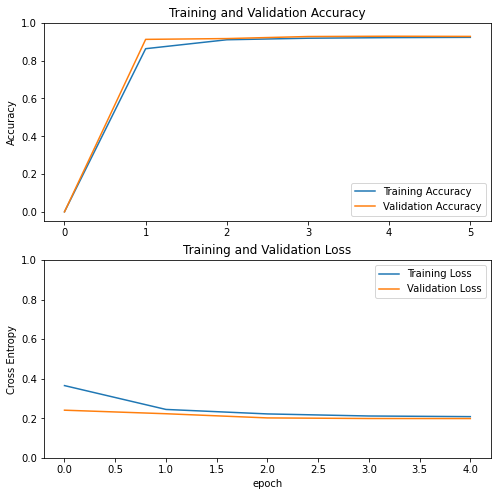

In [19]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
class_names

['caution_triangle_yellow',
 'instruction_circle_blue',
 'instruction_rectangle_blue',
 'instruction_triangle_blue',
 'restriction_circle_red']

In [21]:
base_learning_rate = 0.001

In [22]:
# UNQ_C3
base_model = model2.layers[3]
base_model.trainable = True
#take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120


# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(lr = base_learning_rate*0.1)
# Use accuracy as evaluation metric
metrics=['accuracy']


model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  155


In [23]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
1130/1130 [==============================] - 335s 297ms/step - loss: 0.2403 - accuracy: 0.9105 - val_loss: 0.1645 - val_accuracy: 0.9397
Epoch 6/10
1130/1130 [==============================] - 360s 319ms/step - loss: 0.1368 - accuracy: 0.9502 - val_loss: 0.1141 - val_accuracy: 0.9600
Epoch 7/10
1130/1130 [==============================] - 378s 335ms/step - loss: 0.1068 - accuracy: 0.9630 - val_loss: 0.1130 - val_accuracy: 0.9629
Epoch 8/10
1130/1130 [==============================] - 363s 321ms/step - loss: 0.0906 - accuracy: 0.9681 - val_loss: 0.1060 - val_accuracy: 0.9623
Epoch 9/10
1130/1130 [==============================] - 363s 321ms/step - loss: 0.0818 - accuracy: 0.9716 - val_loss: 0.1166 - val_accuracy: 0.9598
Epoch 10/10
1130/1130 [==============================] - 368s 326ms/step - loss: 0.0720 - accuracy: 0.9751 - val_loss: 0.1050 - val_accuracy: 0.9643


In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

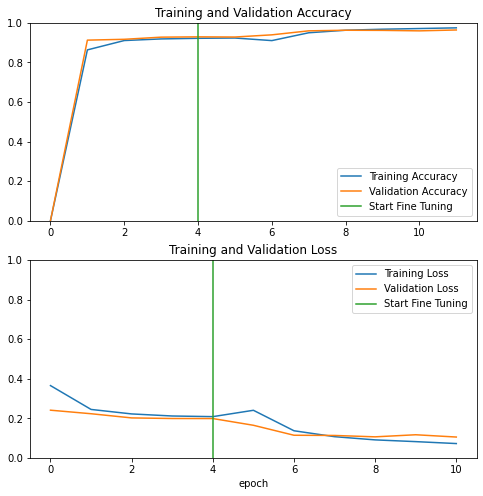

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
import tf2onnx
import onnxruntime as rt

In [27]:
spec = (tf.TensorSpec((None, 299, 299, 3), tf.float32, name="input"),)
output_path = model2.name + ".onnx"

model_proto, _ = tf2onnx.convert.from_keras(model2, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [28]:
model2.save('./mobilev2_model')
model2.save_weights('./mobilev2_weights')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./mobilev2_model\assets


In [29]:
os.system("python -m tf2onnx.convert --saved-model mobilev2_model --output mobilev2.onnx --opset 13")

0